# Data science project in Python - Voorspellingen maken met features

Doormiddel van numpy, pandas, matplotlib & SciKit-learn

Door Louis D'Hont - Elektronica-ICT - 2021

Dit project is het tweede deel van het data science project. Bekijk project-deel-1 om het data cleaning proces te zien.

In [1]:
# Importeren van gebruikte bibliotheken
import datetime
import seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

### Inlezen features

Onderstaande code leest het *featuresDataFrame* bestand in en zet deze om naar een dataframe. In deel 1 van het project is er nog een aanpassing gebeurd, de kolom *Geboortedatum* werd alsnog meegenomen als feature om hierna verdere berekeningen te kunnen doen.

In [2]:
features = pd.read_csv("featuresDataFrame.csv", sep=',') 
features = features.drop(['Unnamed: 0'], axis=1)

### Omzetten van datatypes

De opgeslagen data is bij het inlezen opnieuw van het type int64, float64 en object. De data dat hiervoor een timedelta was ('Aantal dagen tot vertrek' en de 'Aantal dagen op reis' kolom) moet worden omgezet zodat er terug met kan worden gewerkt.

Elk land werd omgezet in een cijfer. De onderstaande lijst toont de eerste 5 landen met hun corresponderende cijfer.

- 1 België
- 2 Nederland
- 3 Frankrijk
- 4 Duitsland
- 5 Groot Brittannië

Elk reistype werd ook eveneens omgezet in een cijfer. De onderstaande lijst toont de reis types met hun corresponderende cijfer.

- 1 Ruitervakantie
- 2 Ponykamp
- 3 Ruitervakantie& Vliegreis
- 4 Trektocht
- 5 Ruitervakantie Eigen Vervoer
- 6 Huifkar tocht
- 7 Safari
- 8 Jeugdkamp
- 9 Weekendje weg

In [3]:
def convert_timedelta(df_col):
    for index, row in enumerate(df_col): 
        days, timestamp = row.split(" days ")
        df_col.iloc[index] = days
    return df_col

def convert_land(df_land):
    for index, row in enumerate(df_land):
        if row == 'be':
            df_land.iloc[index] = 1
        elif row == 'nl':
            df_land.iloc[index] = 2
        elif row == 'fr':
            df_land.iloc[index] = 3
        elif row == 'de':
            df_land.iloc[index] = 4
        elif row == 'gb':
            df_land.iloc[index] = 5  
        elif row == 'lux':
            df_land.iloc[index] = 6
        elif row == 'sco':
            df_land.iloc[index] = 7
        elif row == 'pt':
            df_land.iloc[index] = 8
        elif row == 'sco':
            df_land.iloc[index] = 9
        elif row == 'sr':
            df_land.iloc[index] = 10
        elif row == 'cn':
            df_land.iloc[index] = 11
        elif row == 'aut':
            df_land.iloc[index] = 12
        elif row == 'ca':
            df_land.iloc[index] = 13   
        elif row == 'it':
            df_land.iloc[index] = 14
        elif row == 'es':
            df_land.iloc[index] = 15
        elif row == 'cl':
            df_land.iloc[index] = 16

def convert_reis_type(df_reistype):
    for index, row in enumerate(df_reistype):
        if row == 'Ruitervakantie':
            df_reistype.iloc[index] = 1
        elif row == 'Ponykamp':
            df_reistype.iloc[index] = 2
        elif row == 'Ruitervakantie& Vliegreis':
            df_reistype.iloc[index] = 3
        elif row == 'Trektocht':
            df_reistype.iloc[index] = 4
        elif row == 'Ruitervakantie Eigen Vervoer':
            df_reistype.iloc[index] = 5  
        elif row == 'Huifkar tocht':
            df_reistype.iloc[index] = 6
        elif row == 'Safari':
            df_reistype.iloc[index] = 7
        elif row == 'Jeugdkamp':
            df_reistype.iloc[index] = 8
        elif row == 'Weekendje weg':
            df_reistype.iloc[index] = 9

features['Datum creatie'] = pd.to_datetime(features['Datum creatie'], format='%Y.%m.%d', infer_datetime_format=True, errors='coerce')
features['Datum vertrek'] = pd.to_datetime(features['Datum vertrek'], format='%Y.%m.%d', infer_datetime_format=True, errors='coerce')
features['Datum terug'] = pd.to_datetime(features['Datum terug'], format='%Y.%m.%d', infer_datetime_format=True, errors='coerce')
    
features['Aantal dagen tot vertrek'] == convert_timedelta(features['Aantal dagen tot vertrek'])
features['Aantal dagen tot vertrek'] = features['Aantal dagen tot vertrek'].astype(int)

features['Aantal dagen op reis'] == convert_timedelta(features['Aantal dagen op reis'])
features['Aantal dagen op reis'] = features['Aantal dagen op reis'].astype(int)
            
features['Land'] == convert_land(features['Land'])
features['Land'] = features['Land'].astype(int)

features['Reistype'] == convert_reis_type(features['Reistype'])
features['Reistype'] = features['Reistype'].astype(int)                                     

/Users/louisdhont/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


#### Berekenen leeftijd

De onderstaande code zet de geboortedatum om naar de huidige leeftijd, de lege waarden worden opgevuld met een gemiddelde leeftijd van 40 jaar omdat er kan vanuit worden gegaan dat de gemiddelde persoon 42 jaar is.

In [4]:
features['Geboortedatum'] = pd.to_datetime(features['Geboortedatum'], errors = 'coerce')
features['Leeftijd'] = datetime.datetime.now().year - pd.DatetimeIndex(features['Geboortedatum']).year
features['Leeftijd'] = features['Leeftijd'].fillna(42)
features['Leeftijd'] = features['Leeftijd'].astype(int);

### Omzetten bestemmingen
    
De bestemmingen data is door het bedrijf manueel ingevoerd. Om de bestemmingen te kunnen koppelen aan een land heb  ik gekozen om elk land om te zetten naar een cijfer. Deze onderstaande lijst toont de eerste 10 landen met hun cijfer. Heel wat reizen bevatten geen directe aanwijzing naar het land maar hebben vaak een bekende stad of streek in de omschrijving, door deze te gaan groeperen konden alle bestemmingen worden omgezet naar hun corresponderende cijfer. Een 20 tal bestemmingen bevatte geen duidelijke aanwijzing naar een land of streek, hiervoor heb ik besloten om deze toe te wijzen aan het land waar de meeste reizen naartoe gaan, met name Frankrijk).

- 1 België
- 2 Nederland
- 3 Frankrijk
- 4 Duitsland
- 5 Portugal
- 6 Ijsland
- 7 Italië
- 8 Ierland
- 9 De Verenigde Staten
- 10 Jordanië

In [5]:
nederland = ['friese', 'nederland', 'vlieland', 'brabant', 'twente', 'drenthe', 'limburg', 'brabantse', 'nederlands', 'duinen', 'salland', 'zeeland', 'ijslanders']
belgie = ['ardennen', 'belgium', 'ardenne', 'belgië', 'belgie', 'arrdennen', 'eifel', 'ardennen', 'ardenen']
frankrijk = ['frankrijk', 'mont saint michel', 'morvan', 'dartmoor', 'couleurs corse', 'vogezen', 'margeride', 'haute valee', 'jura', 'normandië', 'médoc', 'montmorillonnais', 'france', 'loire', 'wijnroute', 'wijngaarden', 'elzas', 'pyreneeën', 'dordogne', 'pyreneeen', 'corsica', 'aude', 'frans', 'armagnac', 'frankrijjk', 'frankijk']
duitsland = ['germany', 'duitsland', 'thuringen', 'beieren', 'duitsand', 'duitse', 'thüringen']
spanje = ['spain', 'spanje', 'sulayr', 'alpujarra', 'middellandse', 'demanda', 'monfrague', 'andalusisch', 'costa brava', 'sierra nevada', 'catalonië','catalonie', 'gredos', 'andalusië', 'ronda', 'andalusie', 'conquistadores']
italie = ['italy', 'italie', 'sicilië', 'madonie', 'italië', 'sardinië', 'sardinie', 'toscane', 'molise', 'alta maremma', 'molise abruzzen']
portugal = ['portugal', 'lusitano', 'faro', 'algarve', 'lissabon', 'portugese', 'azoren']
usa = ['verenigde staten', 'montana', 'usa', 'united states', 'wyoming', 'ranch', 'colorado']
kroatie = ['kroatie', 'croatia', 'kroatië', 'istrië', 'plitvice', 'rode-meer', 'dalmatie', 'istrie']
allerlei = ['Klassieke dressuur van topkwaliteit en stedenschoon', 'Avontuurlijke trektocht door een sprookjesachtig gebied', 'Trektocht in het spoor van de tuimelaar-dolfijn ',
       'Driedaagse trektocht in het land van d\x19Oc en d\x19Oil', 'Trektocht over de bergen naar de zee', 'Trektocht in het spoor van de tuimelaar-dolfijn','Paardrijden langs de route van de bandieten', 'De \x18Great Trek\x19: werkelijk avontuurlijke trektocht',
       'Beach and Bush Rides', 'Dressuurweek','Een week paardrijden met jongvolwassenen','National Park: paardrijden voor pure ontspanning',
       'Driedaagse tocht door de Vienne-vallei','Trektocht naar de gouden stranden', 'Oman','Trektocht tussen zee en woestijnbergen', 'Programma Full','Smokkelaarstocht', 'Trektocht over de bergen naar zee','Beach and Meadows trektocht','De "legendes van de Wolf"-trektocht','Standplaatsvakantie Stertochten', 'nan']

def convert_bestemmingen():
    for index, row in enumerate(features['Bestemming']):
        if any(ext in (str(row).lower()) for ext in belgie):
            features['Bestemming'].iloc[index] = 1
        elif any(ext in (str(row).lower()) for ext in nederland):
            features['Bestemming'].iloc[index] = 2
        elif any(ext in (str(row).lower()) for ext in frankrijk):
            features['Bestemming'].iloc[index] = 3
        elif any(ext in (str(row).lower()) for ext in duitsland):
            features['Bestemming'].iloc[index] = 4
        elif any(ext in (str(row).lower()) for ext in portugal):
            features['Bestemming'].iloc[index] = 5
        elif any(ext in (str(row).lower()) for ext in ['ijsland', 'iceland', 'geysir', 'golden circle']):
            features['Bestemming'].iloc[index] = 6
        elif any(ext in (str(row).lower()) for ext in italie):
            features['Bestemming'].iloc[index] = 7
        elif any(ext in (str(row).lower()) for ext in ['ierland', 'ireland', 'galway', 'ierse', 'donegal']):
            features['Bestemming'].iloc[index] = 8
        elif any(ext in (str(row).lower()) for ext in usa):
            features['Bestemming'].iloc[index] = 9
        elif any(ext in (str(row).lower()) for ext in ['jordanie', 'jordan', 'wadi rum']):
            features['Bestemming'].iloc[index] = 10
        elif any(ext in (str(row).lower()) for ext in spanje):
            features['Bestemming'].iloc[index] = 11
        elif any(ext in (str(row).lower()) for ext in ['botswana']):
            features['Bestemming'].iloc[index] = 12
        elif any(ext in (str(row).lower()) for ext in ['canada', 'yukon', 'alberta', 'saskatchewan']):
            features['Bestemming'].iloc[index] = 13
        elif any(ext in (str(row).lower()) for ext in ['roemenie', 'roemenië', 'transsylvanie', 'transsylvanië']):
            features['Bestemming'].iloc[index] = 14
        elif any(ext in (str(row).lower()) for ext in ['chili', 'chile']):
            features['Bestemming'].iloc[index] = 15
        elif any(ext in (str(row).lower()) for ext in ['marokko', 'marokkaanse', 'berbers']):
            features['Bestemming'].iloc[index] = 16
        elif any(ext in (str(row).lower()) for ext in ['griekenland', 'petra', 'kreta', 'kefalonia']):
            features['Bestemming'].iloc[index] = 17
        elif any(ext in (str(row).lower()) for ext in ['zuid afrika', 'afrika']):
            features['Bestemming'].iloc[index] = 18
        elif any(ext in (str(row).lower()) for ext in ['bulgarije', 'bulgaria', 'balkan']):
            features['Bestemming'].iloc[index] = 19
        elif any(ext in (str(row).lower()) for ext in ['hongarije', 'poesta', 'homgarije']):
            features['Bestemming'].iloc[index] = 20
        elif any(ext in (str(row).lower()) for ext in ['tsjechie', 'tsjechië', 'zuid-bohemen', 'karpaten']):
            features['Bestemming'].iloc[index] = 21   
        elif any(ext in (str(row).lower()) for ext in ['cappadocië', 'turkije', 'turklije', 'thracians']):
            features['Bestemming'].iloc[index] = 22
        elif any(ext in (str(row).lower()) for ext in ['polen', 'poolse', 'poland']):
            features['Bestemming'].iloc[index] = 23
        elif any(ext in (str(row).lower()) for ext in ['namibie', 'namibië']):
            features['Bestemming'].iloc[index] = 24
        elif any(ext in (str(row).lower()) for ext in ['kirgizie', 'kirgizië']):
            features['Bestemming'].iloc[index] = 25
        elif any(ext in (str(row).lower()) for ext in ['montenegro']):
            features['Bestemming'].iloc[index] = 26
        elif any(ext in (str(row).lower()) for ext in ['zweden']):
            features['Bestemming'].iloc[index] = 27
        elif any(ext in (str(row).lower()) for ext in ['albanie', 'albanië', 'katharen']):
            features['Bestemming'].iloc[index] = 28
        elif any(ext in (str(row).lower()) for ext in ['mongolië', 'mongolie', 'mongoolse']):
            features['Bestemming'].iloc[index] = 29
        elif any(ext in (str(row).lower()) for ext in kroatie):
            features['Bestemming'].iloc[index] = 30
        elif any(ext in (str(row).lower()) for ext in ['costa rica']):
            features['Bestemming'].iloc[index] = 31
        elif any(ext in (str(row).lower()) for ext in ['slowakije']):
            features['Bestemming'].iloc[index] = 32
        elif any(ext in (str(row).lower()) for ext in ['brazilie', 'santa catarina gaucho']):
            features['Bestemming'].iloc[index] = 33
        elif any(ext in (str(row).lower()) for ext in ['denemarken', 'denmark', 'deense']):
            features['Bestemming'].iloc[index] = 34
        elif any(ext in (str(row).lower()) for ext in ['noorwegen', 'norway', 'ramsjo-special', 'northern', 'scandinavische']):
            features['Bestemming'].iloc[index] = 35
        elif any(ext in (str(row).lower()) for ext in ['azerbidjan']):
            features['Bestemming'].iloc[index] = 36
        elif any(ext in (str(row).lower()) for ext in ['georgie', 'georgië', 'georgia']):
            features['Bestemming'].iloc[index] = 37
        elif any(ext in (str(row).lower()) for ext in ['zwitserland']):
            features['Bestemming'].iloc[index] = 38
        elif any(ext in (str(row).lower()) for ext in ['groot-brittanie', 'wales', 'britain', 'engeland']):
            features['Bestemming'].iloc[index] = 39
        elif any(ext in (str(row).lower()) for ext in ['argentinie', 'argentinië', 'noord-argentinië']):
            features['Bestemming'].iloc[index] = 40
        elif any(ext in (str(row).lower()) for ext in ['cuba']):
            features['Bestemming'].iloc[index] = 41
        elif any(ext in (str(row).lower()) for ext in ['lapland', 'finland']):
            features['Bestemming'].iloc[index] = 42
        elif any(ext in (str(row).lower()) for ext in ['mexico']):
            features['Bestemming'].iloc[index] = 43
        elif any(ext in (str(row).lower()) for ext in ['china']):
            features['Bestemming'].iloc[index] = 44
        elif any(ext in (str(row).lower()) for ext in ['kenia']):
            features['Bestemming'].iloc[index] = 45
        elif any(ext in (str(row).lower()) for ext in ['iran']):
            features['Bestemming'].iloc[index] = 46
        elif any(ext in (str(row).lower()) for ext in ['servië', 'servie', 'sumadija']):
            features['Bestemming'].iloc[index] = 47
        elif any(ext in (str(row).lower()) for ext in ['schotland']):
            features['Bestemming'].iloc[index] = 48
        elif any(ext in (str(row).lower()) for ext in ['egypte', 'sahara']):
            features['Bestemming'].iloc[index] = 49
        elif any(ext in (str(row).lower()) for ext in ['andorra']):
            features['Bestemming'].iloc[index] = 50
        elif any(ext in (str(row).lower()) for ext in ['uruguay']):
            features['Bestemming'].iloc[index] = 51
        elif any(ext in (str(row).lower()) for ext in ['rusland']):
            features['Bestemming'].iloc[index] = 52
        elif any(ext in (str(row).lower()) for ext in ['columbia', 'colombiaans']):
            features['Bestemming'].iloc[index] = 53
        elif any(ext in (str(row).lower()) for ext in ['australie']):
            features['Bestemming'].iloc[index] = 54
        elif any(ext in str(row) for ext in allerlei):
            features['Bestemming'].iloc[index] = 3
    
    return features['Bestemming']

features['Bestemming'] == convert_bestemmingen()
features['Bestemming'] = features['Bestemming'].astype(int)


De onderstaande lijst toont voor elke kolom het datatype. Alle kolommen zijn omgezet naar int, float of datetime. De integer en float waarden kunnen worden gebruikt als feature.

In [6]:
features.dtypes

Status                               int64
Dossier jaar                         int64
Dossier nr.                          int64
Klantnummer                         object
Datum creatie               datetime64[ns]
Datum vertrek               datetime64[ns]
Datum terug                 datetime64[ns]
Totaalprijs                        float64
Betalingen dossier                 float64
Openstaand dossier                 float64
Land                                 int64
Bestemming                           int64
Reistype                             int64
Aantal reizigers                     int64
Aantal dagen tot vertrek             int64
Aantal dagen op reis                 int64
Geboortedatum               datetime64[ns]
Leeftijd                             int64
dtype: object

### Bekijken van features

In het onderstaande dataframe staan alle gegevens die kunnen worden gebruikt als feature. Het spreekt voor zich dat er uiteraard ook enkele minder relevante zaken zoals klantnummer en datums zullen worden weggelaten uit het finale dataframe waarmee de modellen zullen worden opgebouwd.

In [7]:
features.head()

,Status,Dossier jaar,Dossier nr.,Klantnummer,Datum creatie,Datum vertrek,Datum terug,Totaalprijs,Betalingen dossier,Openstaand dossier,Land,Bestemming,Reistype,Aantal reizigers,Aantal dagen tot vertrek,Aantal dagen op reis,Geboortedatum,Leeftijd
0,1,2011,189,030abd64a9a637e5,2011-10-21 12:48:33,2012-04-27,2012-04-29,1600.00,1600.00,0.0,2,2,1,6,188,2,NaT,42
1,1,2011,190,030abd64a9a637e5,2011-10-21 12:56:19,2012-04-27,2012-04-29,1600.00,1600.00,0.0,2,2,1,6,188,2,NaT,42
2,1,2011,191,0517092b51559410,2011-10-26 11:34:16,2012-04-30,2012-04-05,941.66,941.66,0.0,2,4,1,2,186,25,1966-02-19,55
3,1,2011,192,b931980e4256363a,2011-10-26 15:36:35,2012-06-29,2012-11-07,7201.50,7201.50,0.0,2,6,1,3,246,131,NaT,42
4,1,2011,200,7853bb1516f198d9,2011-08-11 16:15:15,2012-04-13,2012-04-22,4291.68,4291.68,0.0,1,10,1,3,245,9,1961-05-03,60


# Evalueren en selecteren van features

Enkele interessante features die in de dataset te vinden zijn:

 - **Status**: De status (1 of 0) heeft aan of de boeking bevestigd of geannuleerd is.
 - **Dossier jaar**: Het jaar waarin het dossier werdt aangemaakt.
 - **Dossier nr.**: Een nummer (id) dat iedere reis identificeert.
 - **Klantnummer**: Het nummer dat een klant identificeert.
 - **Datum creatie**: Deze feature heeft een datum met uur, minuten en seconden. Deze waardes kunnen interessant zijn om te kijken hoeveel tijd er tussen een boeking en de reis vertrek datum zit.
 - **Datum vertrek**: De datum waarop een reis start.
 - **Datum terug**: De datum waarop de reizigers terugkeren naar hun thuisland.
 - **Totaalprijs**: De prijs die ze in totaal betalen voor de reis.
 - **Betalingen dossier**: Het bedrag dat al betaald is.
 - **Openstaand dossier**: Het bedrag dat nog moet betaald worden om te kunnen voldoen en te mogen vertrekken op reis.
 - **Land**: Het thuisland van de reiziger.
 - **Bestemming**: Het land waar de reiziger naartoe geweest is.
 - **Reistype**: Het type reis dat de reiziger neemt.
 - **Aantal reizigers**: Het aantal personen die mee opreis gaan.
 - **Aantal dagen tot vertrek**: Het berekende aantal dagen tussen het aanmaken van een account en de vertrek datum.
 - **Aantal dagen op reis**: Het berekende aantal dagen dat de reis duurde.
 - **Leeftijd**: Leeftijd van de klant.


## Correlatie tussen features

Onderstaande matrix toont aan hoe de features met elkaar verbonden zijn op een schaal van 0 tot 1. Hoe hoger de score bij 1 ligt hoe dichter de features gecorreleerd zijn met elkaar. De correlatie tussen de eigen data is steeds 1 wat ook wordt weergegeven in de diagonale donkerrode lijn.

In de matrix zien we dat er enkele features een goede correlatie hebben met elkaar (hoger dan 0.4).
Zo zijn het aantal reizigers, de totaal prijs en het dossier nummer en jaar best interessante features. Omdat er enkele features (dossier nummer en jaar & Totaalprijs en Betalingen Dossier) een hoge correlatie hebben kan dit zorgen voor overfitting, hierdoor is het best om één van de twee waarden niet op te nemen als feature in het model. Bij het splitten van de train en test data zullen de kolommen 'Dossier nr.' en 'Betalingen Dossier' weggelaten worden.

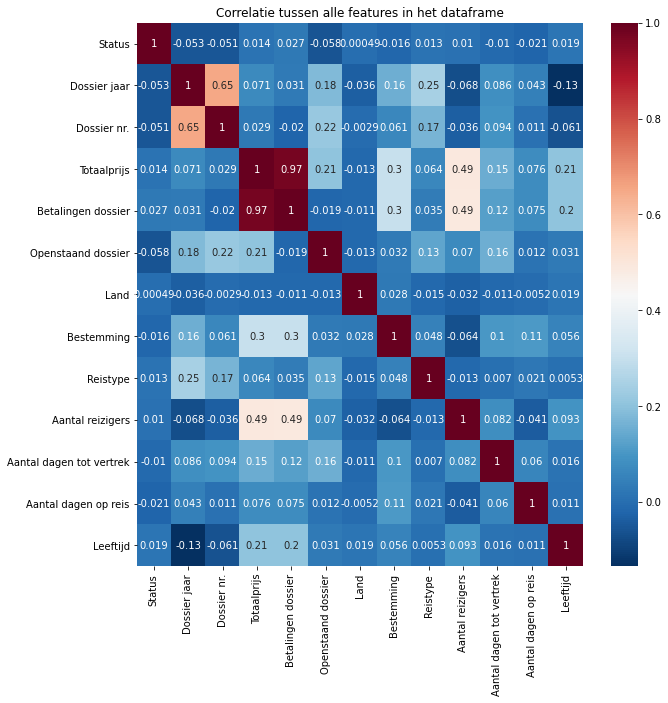

In [8]:
plt.figure(figsize=(10, 10))
plt.title('Correlatie tussen alle features in het dataframe')
seaborn.heatmap((features).corr(), annot=True, cmap="RdBu_r")
plt.show();

### Opsplitsen van train en test data

Onderstaande code splitst de data op in train en test data. In dit geval wordt de data opgesplitst volgens de standaard 75% train data en 25% test data. De niet numerieke kolommen worden uit de dataset weggelaten en de target wordt ingesteld in de 'y' array. Om de data te schalen maak ik gebruik van de StandardScaler. Het idee hierachter is dat het de gegevens zodanig zal transformeren dat de distributie een gemiddelde waarde van 0 en een standaardafwijking van 1 heeft.

Bij Multivariate data gebeurt dit feature-wise (dus onafhankelijk voor elke kolom van de data).
Gezien de verdeling van de gegevens, wordt bij elke waarde in de gegevensset de gemiddelde waarde afgetrokken en vervolgens gedeeld door de standaarddeviatie van de hele gegevensset (of kenmerk in het multivariate geval).

De volgende kolommen worden verwijderd uit het features dataframe:
 - **Klantnummer** Een klantnummer is geen numerieke waarde dus dit kan niet meegeven worden aan modellen.
 - **Geboortedatum** De kolom met geboortedatums is geen numerieke waarde en de leeftijd is hieruit berekend dat wel als feature kan dienen.
 - **Dossier nr.** De kolom met de dossier nummers had een hoge correlatie met het dossier jaar waardoor het interessant is om deze niet mee op te nemen in de features lijst, dit kan het model ten goede komen omdat er overfitting kan ontstaan met hoog gecorreleerde features onderling.
 - **Betalingen dossier** Het bedrag dat al reeds betaald was is ook hoog gecorreleerd met het totaal bedrag waardoor deze kolom ook kan worden weggelaten uit de features.
 - **Datums** De kolommen *Datum creatie*, *Datum vertrek* en *Datum terug* zijn datums die al gebruikt zijn om zaken te berekenen (Aantal dagen op reis en Aantal dagen tot vertrek).

In [9]:
def scale_data(df):
    X = df.drop(['Aantal dagen tot vertrek', 'Klantnummer', 'Openstaand dossier', 'Totaalprijs', 'Geboortedatum', 'Dossier nr.', 'Betalingen dossier',  'Datum creatie', 'Datum vertrek', 'Datum terug'], axis=1)
    y = df['Aantal dagen tot vertrek']
    scaler = StandardScaler()
    scaler.fit(X)
    return scaler.transform(X), y

X, y = scale_data(features)
# split voor KNN en al de rest + maak functie van bovenstaande code
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [10]:
#mag weg
#y = features['Aantal dagen tot vertrek'].to_numpy().astype(int)
#X = features.drop(['Aantal dagen tot vertrek', 'Klantnummer', 'Openstaand dossier', 'Totaalprijs', 'Geboortedatum', 'Dossier nr.', 'Betalingen dossier',  'Datum creatie', 'Datum vertrek', 'Datum terug'], axis=1)
#X_train, X_test, y_train, y_test = train_test_split(X, y)

De geschaalde data in het dataframe *X*.

In [11]:
X

array([[  0.06367683,  -2.09338933,   0.33372771, ...,   3.50094482,
         -0.81901982,  -0.30435306],
       [  0.06367683,  -2.09338933,   0.33372771, ...,   3.50094482,
         -0.81901982,  -0.30435306],
       [  0.06367683,  -2.09338933,   0.33372771, ...,   0.19740368,
         -0.53761994,   1.02041738],
       ...,
       [  0.06367683,   1.98790608,   0.33372771, ...,   0.19740368,
          0.64915343,   0.20517403],
       [-15.70429877,   1.98790608,   0.33372771, ...,   0.19740368,
          1.75028337,  -0.30435306],
       [  0.06367683,   1.98790608,   0.33372771, ...,   0.19740368,
         -0.80678504,  -2.7500831 ]])

De vorm van de *X* en *y* array wordt hieronder afgeprint. De *X* dataset bevat 10 features (kolommen) en 3962 rijen, de *y* array bevat de target data met 1 kolom en 3962 rijen aan data. Het aantal rijen en features van de trainings- en testset worden ook weergegeven. De trainingsset bedraagt 2971 rijen aan data en de testset 991 rijen.

In [12]:
print("Shape van de X data:", X.shape)
print("Shape van de y target data:", y.shape)

Shape van de X data: (3962, 8)
Shape van de y target data: (3962,)


In [13]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Aantal features:", X.shape[1])

X_train shape: (2971, 8)
y_train shape: (2971,)
X_test shape: (991, 8)
y_test shape: (991,)
Aantal features: 8


## Modellen evalueren, vergelijken en testen

In de volgende stappen worden enkele modellen getest om te zien hoe de modellen het doen op de train en test data.

### KNN

KNN is het eenvoudigste model dat we gaan uittesten. Het onthoudt de trainingsgegevens en plaatst de te voorspellen gegevens in dezelfde grafiek. Om elk doel te voorspellen, zoekt het KNN-model het dichtstbijzijnde punt in de trainingsdata en stelt de waarde van het te voorspellen gegeven in op dat van de dichtstbijzijnde buur. Er kan ingesteld worden hoeveel buren het model moet gebruiken om een waarde aan het doel te geven. Meer of minder buren kiezen kan een goede of slechte invloed hebben op het classificerings model.

### Decision tree

Een decision tree is een algoritme dat gebruikmaakt van een boomachtig model om beslissingen te maken en hun mogelijke gevolgen te gaan afwegen. Het is een algoritme dat alleen voorwaardelijke controle-instructies bevat en op basis daarvan tot een voorspelling komt.

Decision trees hebben 2 hoofdzakelijke types:

* Classification tree is wanneer de voorspelde uitkomst de klasse is waartoe de gegevens behoren.
* Regression is wanneer de voorspelde uitkomst als een reëel getal kan worden beschouwd (bijvoorbeeld de prijs van een huis of de leeftijd van een persoon).

### Logistic regression

Logistic regression is een statistische methode voor het voorspellen van binaire klassen. De uitkomst- of doelvariabele is dichotoom van aard. Dichotoom betekent dat er maar twee mogelijke klassen zijn (binair). Het is een speciaal geval van lineaire regressie waarbij de doelvariabele categorisch van aard is. Logistische regressie voorspelt de waarschijnlijkheid van optreden van een binaire gebeurtenis met behulp van een logitfunctie.

### Random Forest tree

Random forest is een verzameling van decision trees. Het Random Forest algoritme werkt volgens de *bootstrap aggregating* (bagging) techniek, hierbij worden door middel van trekkingen een aantal sub-datasets uit de data genomen, op basis waarvan worden decision trees opgesteld. De predictie voor een nieuwe observatie wordt vervolgens bepaald door het gemiddelde van de predicties van de verschillende decision trees te nemen. Omdat de decision trees veel op elkaar kunnen lijken en één of een beperkt aantal verklarende variabelen dominant kunnen zijn, wordt er bij iedere splitsing een subset van de verklarende variabelen gebruikt op basis van enkele trekking.

Het Random Forest algoritme heeft als voordeel dat het met grote hoeveelheden data te omgaan

## Testen van verschillende modellen

### KNN-model

Onderstaande code print voor elke iteratie de train en test score uit met 4 grafieken. De twee linkse grafieken tonen het percentage per aantal neighbors op de hele trainingsset. De twee rechtse grafieken tonen het percentage per aantal neighbors op de testdata. Hieruit blijkt dat op de trainingsdata het slaagpercentage afzwakt naarmate er meer neighbors bijkomen. Wat opvalt is dat bij 1 en 2 neightbors bij de trainingsset tegenover de testset er duidelijk overfitting optreedt.

Ik gebruik de Elbow methode om de beste waarde voor k (aantal neightbors) te vinden, deze waarde is dan af te lezen van de grafiek en wordt uitgeprint voor iedere iteratie met de bijhorende train en test scores. In mijn opstelling zal deze later ingesteld worden op 3, nadien doen we voor de evaluatie van het model nogmaals dezelfde stappen maar deze keer met een niet variabele k.

Tijdens het uittesten van het KNN-model viel me op dat het schalen van de data met de StandardScaler een positief maar kleine verbetering gaf in de train- en testdata.

Iteratie: 1
Accuracy on training set: 0.848
Accuracy on test set: 0.046
*-------------------------------*
Iteratie: 2
Accuracy on training set: 0.490
Accuracy on test set: 0.032
*-------------------------------*
Iteratie: 3
Accuracy on training set: 0.353
Accuracy on test set: 0.026
*-------------------------------*
Iteratie: 4
Accuracy on training set: 0.278
Accuracy on test set: 0.027
*-------------------------------*
Iteratie: 5
Accuracy on training set: 0.232
Accuracy on test set: 0.025
*-------------------------------*
Iteratie: 6
Accuracy on training set: 0.204
Accuracy on test set: 0.022
*-------------------------------*
Iteratie: 7
Accuracy on training set: 0.179
Accuracy on test set: 0.021
*-------------------------------*
Iteratie: 8
Accuracy on training set: 0.167
Accuracy on test set: 0.022
*-------------------------------*
Iteratie: 9
Accuracy on training set: 0.158
Accuracy on test set: 0.020
*-------------------------------*
Iteratie: 10
Accuracy on training set: 0.146
A

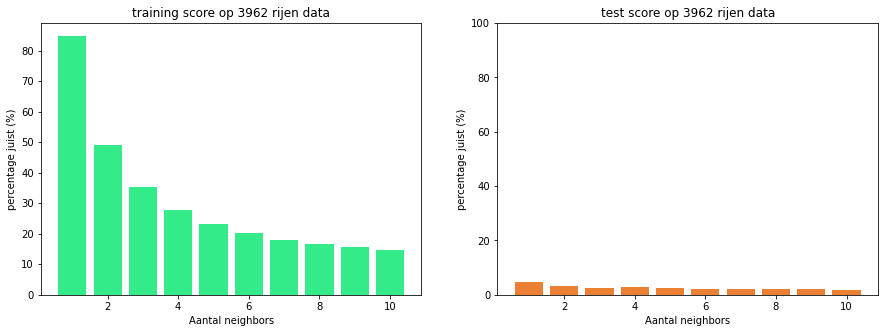

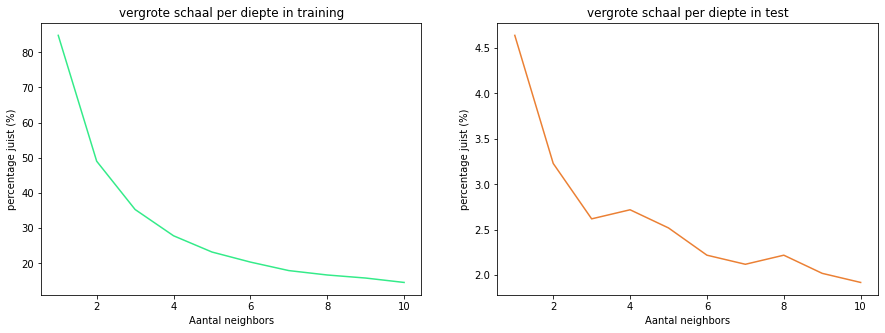

In [14]:
trainingScore = []
testScore = []
neighbors = 10

for k in range(1, neighbors + 1):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    
    trainingScore.append(round(knn.score(X_train, y_train) * 100, 2))
    testScore.append(round(knn.score(X_test, y_test) * 100, 2))
    
    print("Iteratie: " + str(k))
    print("Accuracy on training set: {:.3f}".format(knn.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(knn.score(X_test, y_test)))
    print("*-------------------------------*")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
objects = range(1, neighbors + 1)

ax1.bar(objects, trainingScore, align='center', color = "#34eb89")
ax1.set_title('training score op ' + str(len(X)) + ' rijen data')
ax1.set_ylabel('percentage juist (%)')
ax1.set_xlabel('Aantal neighbors')

ax2.bar(objects, testScore, align='center', color = "#eb8034")
ax2.set_ylim(0, 100)
ax2.set_title('test score op ' + str(len(X)) + ' rijen data')
ax2.set_ylabel('percentage juist (%)')
ax2.set_xlabel('Aantal neighbors')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(objects, trainingScore, color = "#34eb89")
ax1.set_title('vergrote schaal per diepte in training')
ax1.set_ylabel('percentage juist (%)')
ax1.set_xlabel('Aantal neighbors')

ax2.plot(objects, testScore, color = "#eb8034")
ax2.set_title('vergrote schaal per diepte in test')
ax2.set_ylabel('percentage juist (%)')
ax2.set_xlabel('Aantal neighbors')
plt.show()

### Finaal KNN-model met vaste waarde

We zien hieronder een duidelijke overfitting optreden (een beter prestatie van het model op de trainingsset als op de testset). De k waarde is zo optimaal mogelijk gekozen maar omdat het een relatief kleine dataset is wordt het moeilijker om een goede voorspelling te doen en is de testscore zeer laag. Hoe hoger het aantal neightbors (k) hoe slechter de trainingsset zal scoren, de testset zakt eveneens mee omlaag. Bij 1 neightbor is de trainingsscore zeer hoog, door overfitting blijft de testscore ook zeer laag (+/- 5%).

In [15]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
trainingScore = round(knn.score(X_train, y_train), 2)
testScore = round(knn.score(X_test, y_test), 2)

print("Training set score: " + str(trainingScore))
print("Test set score: " + str(testScore))

Training set score: 0.85
Test set score: 0.05


### Decision tree classifier model

Onderstaande code print voor elke iteratie de train en test score uit met 4 grafieken. De twee linkse grafieken tonen het percentage voor elke diepte op de hele trainingsset. De twee rechtse grafieken tonen het percentage van de testdata voor elke diepte. Hieruit blijkt dat op de trainingsdata het slaagpercentage toeneemt bij een hogere diepte, dit blijft doorgaan tot een diepte van 40, hierna vlakt de score af tot 85% en wordt deze niet beter. Het is uiteraard ook niet goed om een te hoge diepte in te stellen omdat er dan te veel opsplitsingen gebeuren en zo het model te specifiek wordt getrained op de aangeleverde dataset. Het Decision tree algoritme is ook heel wat sneller dan het KNN classifier model.

De 2 onderste grafieken geven een ingezoomde lijn grafiek weer om het verloop tussen beter zichtbaar te maken.

Iteratie: 1
Accuracy on training set: 0.011
Accuracy on test set: 0.005
*-------------------------------*
Iteratie: 2
Accuracy on training set: 0.012
Accuracy on test set: 0.006
*-------------------------------*
Iteratie: 3
Accuracy on training set: 0.015
Accuracy on test set: 0.005
*-------------------------------*
Iteratie: 4
Accuracy on training set: 0.019
Accuracy on test set: 0.007
*-------------------------------*
Iteratie: 5
Accuracy on training set: 0.023
Accuracy on test set: 0.007
*-------------------------------*
Iteratie: 6
Accuracy on training set: 0.029
Accuracy on test set: 0.008
*-------------------------------*
Iteratie: 7
Accuracy on training set: 0.037
Accuracy on test set: 0.009
*-------------------------------*
Iteratie: 8
Accuracy on training set: 0.048
Accuracy on test set: 0.012
*-------------------------------*
Iteratie: 9
Accuracy on training set: 0.060
Accuracy on test set: 0.014
*-------------------------------*
Iteratie: 10
Accuracy on training set: 0.076
A

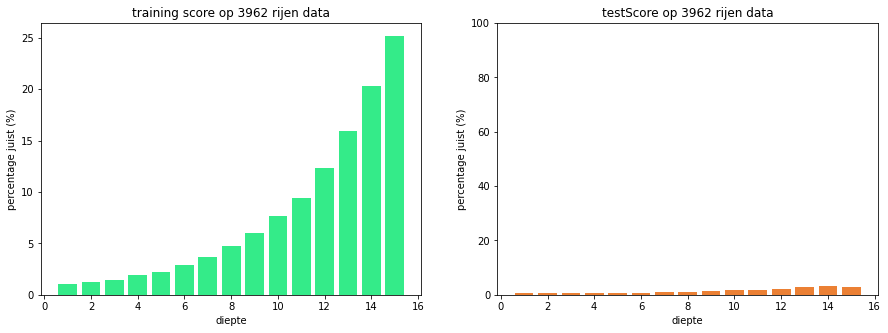

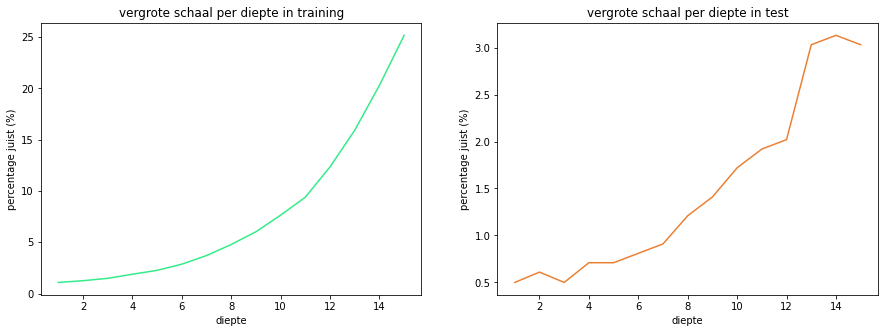

In [16]:
trainingScore = []
testScore = []
depth = 15

for n in range(1, depth + 1):
    treeModel = DecisionTreeClassifier(max_depth=n, random_state=42).fit(X_train, y_train)
    
    trainingScore.append(round(treeModel.score(X_train, y_train) * 100, 2))
    testScore.append(round(treeModel.score(X_test, y_test) * 100, 2))
    print("Iteratie: " + str(n))
    print("Accuracy on training set: {:.3f}".format(treeModel.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(treeModel.score(X_test, y_test)))
    print("*-------------------------------*")
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
objects = range(1, depth + 1)


ax1.bar(objects, trainingScore, align='center', color = "#34eb89")
ax1.set_title('training score op ' + str(len(X)) + ' rijen data')
ax1.set_ylabel('percentage juist (%)')
ax1.set_xlabel('diepte')

ax2.bar(objects, testScore, align='center', color = "#eb8034")
ax2.set_ylim(0, 100)
ax2.set_title('testScore op ' + str(len(X)) + ' rijen data')
ax2.set_ylabel('percentage juist (%)')
ax2.set_xlabel('diepte')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(objects, trainingScore, color = "#34eb89")
ax1.set_title('vergrote schaal per diepte in training')
ax1.set_ylabel('percentage juist (%)')
ax1.set_xlabel('diepte')

ax2.plot(objects, testScore, color = "#eb8034")
ax2.set_title('vergrote schaal per diepte in test')
ax2.set_ylabel('percentage juist (%)')
ax2.set_xlabel('diepte')
plt.show()

### Finaal Decision tree model

We zien hieronder terug een duidelijke overfitting optreden (een beter prestatie van het model op de trainingsset als op de testset). De decision tree is bij een hoge diepte acurater maar het bljft slecht scoren op de testset. Overfitting blijft steeds optreden, in de grafieken hierboven zagen we ook dat de test scores zeer weinig stegen tegenover de trainings scores.

In [17]:
trainingScore = []
testScore = []

treeModel = DecisionTreeClassifier(max_depth=15, random_state=42).fit(X_train, y_train)
trainingScore = round(treeModel.score(X_train, y_train), 2)
testScore = round(treeModel.score(X_test, y_test), 2)

print("Cross validation score: " + str(cross_val_score(treeModel, X_train, y_train, cv=5)))
print("Training set score: " + str(trainingScore))
print("Test set score: " + str(testScore))

Cross validation score: [0.04201681 0.02188552 0.02356902 0.02525253 0.05218855]
Training set score: 0.25
Test set score: 0.03


/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


### Logistic regression

Logistic regression is een lineair model voor classificatie. Het gebruikte algoritme heet *Solver*. De solver is ingesteld op *liblinear* aangezien dit een multiclass dataset kan verwerken en dit gebaseerd is op kansverhoudingen. De verhouding tussen de fracties bij twee mogelijke uitkomsten wordt hierin bepaald en zo geclassificeerd. Dit principe wordt uitgevoerd en vervolgens herhaald indien het in de rest thuishoort (een soort van binaire classificatie).

De score is in beide gevallen zeer laag op de tranings- en testset omdat dit een binair clasificatie methode is. Hierdoor is het dus een algoritme dat niet kan worden gebruikt in dit project.

In [18]:
trainingScore = []
testScore = []

logRegr = LogisticRegression(solver='liblinear', max_iter=500, multi_class = 'auto').fit(X_train, y_train)
trainingScore.append(round(logRegr.score(X_train, y_train) * 100, 2))
testScore.append(round(logRegr.score(X_test, y_test) * 100, 2))

print("Accuracy on training set: {:.3f}".format(logRegr.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(logRegr.score(X_test, y_test)))

Accuracy on training set: 0.035
Accuracy on test set: 0.008


### Random forest tree

Ook hier zijn de beste parameters voor het model gekozen door middel van *GridSearchCV*. 

Ik zien hier een zware overfitting, dit ga ik oplossen door *feature importance*. Dit wil eigenlijk zeggen dat mijn model de waardes voor mijn test set te precies gaat volgen, er is een te hoge variantie (ruis wordt mee opgenomen) de bias daar tegen over zal eerder laag zijn voor dit model.

In [19]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, np.ravel(y_train, order='C'))

y_predForest = forest.predict(X_test)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train), 2))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test), 2))

Accuracy on training set: 0.851
Accuracy on test set: 0.057


## cross-validation

Cross validatie is een techniek om te beschermen tegen overfitting in een model. Bij cross validatie wordt er een vast aantal folds (of partities) van de gegevens genomen, daarna wordt de analyse uitgevoerd op elke fold en een gemiddelde van de totale foutschatting berekend.

Deze techniek wordt hieronder uitgevoerd met KNN (k-nearest neighbors), Linaire regressie en Decision tree.

### Cross validation met KNN

In [31]:
kFold = KFold(n_splits=10, shuffle=True, random_state=42)

KNN = KNeighborsClassifier(n_neighbors = 5).fit(X_train, y_train)

df_knn = pd.DataFrame(cross_validate(KNN, X, y, cv=kFold, return_train_score=True))
scores = cross_val_score(KNN, X, y, cv = 2)

print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))
df_knn

Cross-validation scores: [0.01060071 0.01261989]
Average cross-validation score: 0.01


/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


,fit_time,score_time,test_score,train_score
0,0.009714,0.024687,0.032746,0.230014
1,0.009427,0.026721,0.035264,0.237027
2,0.007417,0.018848,0.025253,0.234997
3,0.011564,0.028434,0.027778,0.236680
4,0.007041,0.018509,0.022727,0.233034
5,0.007339,0.018194,0.037879,0.228828
6,0.007209,0.018320,0.037879,0.226865
7,0.007111,0.018464,0.027778,0.231632
8,0.007085,0.018570,0.025253,0.227987
9,0.007298,0.018821,0.022727,0.236960


### Cross validation met linear regression

In [28]:
linair = LinearRegression().fit(X_train, y_train)

df_lin = pd.DataFrame(cross_validate(linair, X, y, cv=kFold, return_train_score=True))
scores = cross_val_score(linair, X, y)

print("Average cross-validation score: {:.2f}".format(scores.mean()))
df_lin

Average cross-validation score: -0.01


,fit_time,score_time,test_score,train_score
0,0.002715,0.000745,0.042553,0.025785
1,0.001634,0.000540,0.034060,0.026742
2,0.001603,0.000549,0.015984,0.028556
3,0.001497,0.000470,-0.002837,0.029392
4,0.001737,0.000586,0.026268,0.027630
5,0.001716,0.000590,0.020365,0.028023
6,0.001478,0.000682,0.022327,0.027851
7,0.001527,0.000486,0.029225,0.026999
8,0.001428,0.000475,0.028545,0.027258
9,0.001459,0.000490,-0.003177,0.030190


### Cross validation met decision tree

In [29]:
decTree = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_train, y_train)

df_dec = pd.DataFrame(cross_validate(decTree, X, y, cv=kFold, return_train_score=True))
scores = cross_val_score(decTree, X, y)

print("Average cross-validation score: {:.2f}".format(scores.mean()))
df_dec

Average cross-validation score: 0.01


/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


,fit_time,score_time,test_score,train_score
0,0.005970,0.001340,0.005038,0.024404
1,0.005504,0.001179,0.020151,0.020196
2,0.005510,0.000656,0.005051,0.020471
3,0.005568,0.000700,0.022727,0.019630
4,0.005717,0.000743,0.015152,0.020191
5,0.005504,0.000626,0.002525,0.021873
6,0.005407,0.000700,0.025253,0.020752
7,0.005579,0.000679,0.012626,0.020752
8,0.005437,0.000609,0.010101,0.021873
9,0.005160,0.000625,0.002525,0.021593


### Grid Search

GridSearch in Decision tree

Hieronder: belangrijkheid van elke feature...

In [23]:
importance = gridSearchTrees.best_estimator_.feature_importances_

dfFeatureImp = pd.DataFrame(importance, index=featureNames, columns=['feature importance']).sort_values('feature importance', ascending=False)
bar = dfFeatureImp.plot(kind='barh', color = "#ED4E3E", legend = None)

plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("Belangrijkheid van de features")
bar.spines['top'].set_visible(False)
bar.spines['right'].set_visible(False)
bar.spines['left'].set_visible(False)
plt.show();

NameError: name 'gridSearchTrees' is not defined

In [ ]:
best_score = 0

for depth in range(1, 15):
    for rs in [0, 5, 10, 20, 42]:
        tree = DecisionTreeClassifier(max_depth=depth, random_state=rs)
        tree.fit(X_train, y_train)
        score = tree.score(X_valid, y_valid)
        
        if score > best_score:
            best_score = score
            best_parameters = {'max_depth': depth, 'random_state': rs}
            if score > topScore:
                topScore = score
                bm = tree

print("Best parameters: ", best_parameters)

tree = DecisionTreeClassifier(**best_parameters)
tree.fit(X_train_validation, y_train_validation)
training_score = tree.score(X_train, y_train)
test_score = tree.score(X_test, y_test)

print("\nTraining set score with best parameters : {:.2f}".format(training_score))
print("Best score on validation set: {:.2f}".format(best_score))
print("Test set score with best parameters: {:.2f}".format(test_score))

In [ ]:
# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)

# split train+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)

print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

In [ ]:
# vind de beste parameters
from sklearn.tree import DecisionTreeClassifier
## beste parameters zoeken voor het decision tree model
best_score = 0

# make a grid for parameter tuning
for depth in [1,2,3,4,5]:
    for rs in [0,5,10,20,40]:
    # for each combination of parameters train a decisiontree
        tree = DecisionTreeClassifier(max_depth=depth, random_state=rs)
        tree.fit(X_train, y_train)
        # evaluate for the validation set
        score = tree.score(X_valid, y_valid)
        # store the best scores
        if score > best_score:
            best_score = score
            best_parameters = {'max_depth': depth, 'random_state': rs}

print("Best parameters: ", best_parameters)

In [ ]:
# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
tree = DecisionTreeClassifier(**best_parameters)
tree.fit(X_trainval, y_trainval)
training_score = tree.score(X_train, y_train)
test_score = tree.score(X_test, y_test)

print("Training set score with best parameters : {:.2f}".format(training_score))
print("Best score on validation set: {:.2f}".format(best_score))
print("Test set score with best parameters: {:.2f}".format(test_score))

# Grid search in combinatie met Cross-validatie

## PAS AAN!

De beste parameters voor het model kunnen bepaald worden met *GridSearch* in combinatie met *Cross validation*, ook wel *GridSearchCV* genoemd. Met deze combinatie kan het model algemener getest worden en een betere accuracy krijgen. We zien in dit model geen over- of underfitting

De accuracy op de test is hetzelfde als op de training, al ligt deze wel aan de lage kant. Ook hier ga ik in een verder evaluatie nog met de features experimenteren om dit omhoog te krijgen. Dit doe ik ook via feature selection methoden, zoals Principal component en singular value decomposition.

In [ ]:
#fill parameter grid for this model
param_grid = {'random_state': [0, 1, 2, 3, 4, 5]}

#do a gridsearchCV, this will decide the best parameters for the model 
#and usses a validation set to minimalize overfitting of the training set
gridSearchLogReg = GridSearchCV(LogisticRegression(solver="liblinear", multi_class="auto"), param_grid, cv=5, return_train_score=True)

gridSearchLogReg.fit(X_train, y_train)
pred = gridSearchLogReg.predict(X_test)
trainingScoreLogReg = round(gridSearchLogReg.score(X_train, y_train), 2)
testScoreLogReg = round(gridSearchLogReg.score(X_test, y_test), 2)

print("Training set score: " + str(trainingScoreLogReg))
print("Test set score: " + str(testScoreLogReg))

print("Best parameters: {}".format(gridSearchLogReg.best_params_))
print("Best cross-validation score: {:.2f}".format(gridSearchLogReg.best_score_))

#print("\nConfusion matrix:")
#print(confusion_matrix(y_test,pred))
#print("\nClassification report:")
#print(classification_report(y_test,pred))

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [1,2,3,4,5], 'random_state': [0,5,10,20,40]}
print("Parameter grid:\n{}".format(param_grid))

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5,
                          return_train_score=True)
# do not overfit the parameters !
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
grid_search.fit(X_train, y_train)
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

# TODO: Visualisatie van de GridSearchCV aan de hand van een heat map

Samenvatting deel 1

Doel : generalisatie vermogen van het model verbeteren op reële data.

1 test set gebruiken om accuracy te berekenen is erg beperkt

cross-validatie en varianten geven je betere accuracy voorspelling maar is uiteraard rekenintensief
parametertuning en gridsearch technieken helpen om generalisatievermogen te verhogen, let wel dat je hierbij de testset niet gaat overfitten :

  - maak gebruik van een validatieset
  - doe de combinatie van gridsearch / cross-validatie (opnieuw : rekenintensief!)
  
  
## Deel 2

Metrieken om beter te evalueren

metrieken gebruikt tot dusver :

voor classificatie : accuracy : tel het aantal juist geclassificeerde data-elementen in de testset tov de grootte van de testset

voor regressie : MSE : mean-squared-error : bereken het verschil tussen voorspelde en werkelijke waarde, kwadrateer deze fouten en neem hier een gemiddelde van